In [202]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


# Load train and test data
train_df = pd.read_csv('train.csv')
#test_df = pd.read_csv('test.csv')
# Sample 10% of your training data for testing code functionality
sample_train_df = train_df.sample(frac=0.01, random_state=42)
sample_train_df.shape


(420, 785)

In [203]:

# Separate features and labels in the training data
X = sample_train_df.drop('label', axis=1)
y = sample_train_df['label']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [204]:
X_train.shape

(294, 784)

In [205]:
# Assuming X is your dataset

# Mean
X_mean = X_train.mean()

# Standard deviation
X_std = X_train.std()

# Standardization
Z = (X_train - X_mean) / X_std

# Covariance matrix
c = np.cov(Z, rowvar=False)


In [206]:

# Calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(c)

# Sort eigenvalues in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]

# Calculate explained variance ratio
explained_variance_ratio = sorted_eigenvalues / np.sum(sorted_eigenvalues)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Set desired variance threshold
desired_variance_retained = 0.95

n_components = np.argmax(cumulative_variance >= desired_variance_retained) + 1

print("Number of components to retain {}% variance: {}".format(desired_variance_retained * 100, n_components))


Number of components to retain 95.0% variance: 115


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


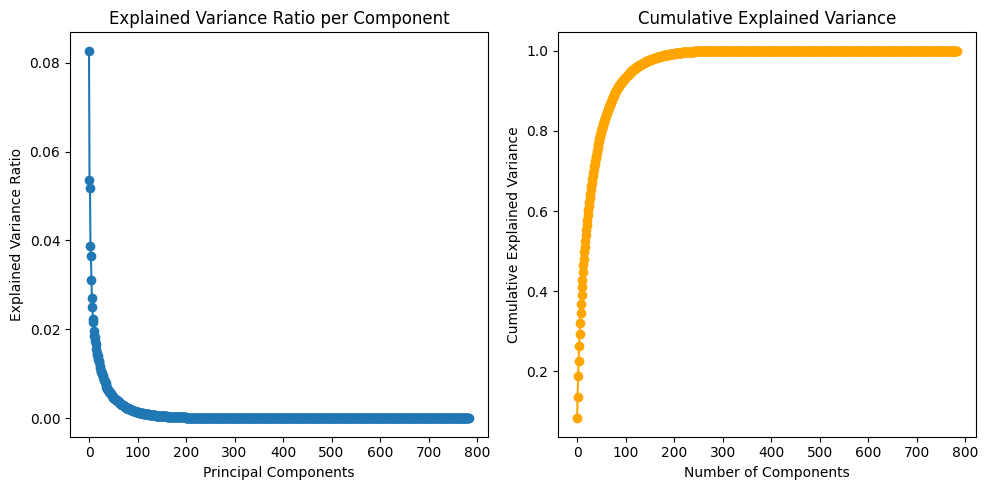

In [207]:

# Plot explained variance ratio and cumulative explained variance
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(explained_variance_ratio, marker='o')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio per Component')

plt.subplot(1, 2, 2)
plt.plot(cumulative_variance, marker='o', color='orange')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')

plt.tight_layout()
plt.show()


In [208]:
from sklearn.decomposition import PCA
# Initialize PCA
pca = PCA(n_components=145)  # You can set the explained variance threshold here

# Fit PCA on the scaled training data
pca.fit(X_train)

# Transform both the training and test sets
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


In [209]:
X_train_pca.shape

(294, 145)

In [210]:
selected_features = pca.components_

# Print the selected features
print("Selected Features by PCA:")
for i, component in enumerate(selected_features):
    print(f"Principal Component {i+1}:")
    for j, feature in enumerate(X.columns):
        print(f"Feature {feature}: {component[j]}")
    print()

Selected Features by PCA:
Principal Component 1:
Feature pixel0: -8.428673514292362e-18
Feature pixel1: 7.946545814487867e-19
Feature pixel2: -1.2057811870973133e-17
Feature pixel3: -4.413173584732308e-17
Feature pixel4: 1.1629234280937839e-17
Feature pixel5: 2.433292156730554e-18
Feature pixel6: 9.507820917841511e-18
Feature pixel7: -1.0338997296709943e-17
Feature pixel8: 1.061554236750195e-19
Feature pixel9: 6.62206070603706e-21
Feature pixel10: -6.482759380160161e-19
Feature pixel11: 8.944363284246147e-19
Feature pixel12: 1.3480535031313995e-18
Feature pixel13: -1.3111907683218067e-19
Feature pixel14: 1.7991794550392745e-20
Feature pixel15: 4.085853657494225e-21
Feature pixel16: 2.419110182573452e-19
Feature pixel17: -2.0799583269171935e-19
Feature pixel18: 2.159461651482873e-20
Feature pixel19: -4.670210088968611e-20
Feature pixel20: 7.66720541655641e-21
Feature pixel21: 3.473774053487314e-20
Feature pixel22: 5.145293264963381e-21
Feature pixel23: 9.649292644147174e-21
Feature pixe

# SVM


In [211]:

# Initialize SVM classifier
svm_model = SVC()

# Define parameters for grid search
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly']
}

# Perform grid search for SVM
svm_grid_search = GridSearchCV(svm_model, svm_param_grid, cv=5)
svm_grid_search.fit(X_train_pca, y_train)

# Get best parameters for SVM
best_svm_params = svm_grid_search.best_params_
print("Best Parameters for SVM after PCA:", best_svm_params)

# Use best SVM model from grid search
best_svm_model = svm_grid_search.best_estimator_

# Make predictions on the PCA-transformed test set using SVM
y_svm_pred = best_svm_model.predict(X_test_pca)

# Calculate accuracy for SVM after PCA
svm_accuracy = accuracy_score(y_test, y_svm_pred)
print("SVM Accuracy after PCA:", svm_accuracy * 100)


Best Parameters for SVM after PCA: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
SVM Accuracy after PCA: 84.92063492063492


# Decision Tree Classifier

In [212]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier()

# Define parameters for grid search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(tree_model, param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)

# Get best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


Best Parameters: {'criterion': 'entropy', 'max_depth': 40, 'min_samples_leaf': 2, 'min_samples_split': 10}


In [213]:

# Use best model from grid search
best_model_dt = grid_search.best_estimator_
y_pred_dt = best_model_dt.predict(X_test_pca)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_dt)
print("Accuracy:", accuracy * 100)


Accuracy: 42.06349206349206


# Random Forest

In [214]:
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier()

# Define parameters for grid search
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Perform grid search
grid_search = GridSearchCV(forest_model, param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)

# Get best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


Best Parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [215]:

# Use best model from grid search
best_model_rt = grid_search.best_estimator_


y_pred_rt = best_model_rt.predict(X_test_pca)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_rt)
print("Accuracy:", accuracy * 100)


Accuracy: 71.42857142857143


# K-Nearest Neighbour

In [216]:
from sklearn.neighbors import KNeighborsClassifier

# Define KNN model
knn_model = KNeighborsClassifier()

# Define parameters for grid search
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Test different values for K
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']  # Different distance metrics
}

# Perform grid search
grid_search = GridSearchCV(knn_model, param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)

# Get best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


In [217]:

# Use best model from grid search
best_model_knn = grid_search.best_estimator_

y_pred_knn = best_model_knn.predict(X_test_pca)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_knn)
print("Accuracy:", accuracy * 100)


Accuracy: 68.25396825396825


# CNN

In [218]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Load the training and test data
train_df = pd.read_csv('train.csv')
#test_df = pd.read_csv('test.csv')

# Sample 10% of your training data for testing code functionality
sample_train_df = train_df.sample(frac=0.01, random_state=42)

# Separate features and labels in the training data
X = sample_train_df.drop('label', axis=1)
y = sample_train_df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)


In [219]:
from sklearn.decomposition import PCA
# Initialize PCA
pca = PCA(n_components=115)  # You can set the explained variance threshold here

# Fit PCA on the scaled training data
pca.fit(X_train)

# Transform both the training and test sets
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


In [220]:
print(X_train_processed.shape)
print(y_train_processed.shape)


(294, 115, 1)
(294, 10)


In [221]:
# Preprocess the data
X_train_processed = X_train_pca.reshape(-1, 115, 1).astype('float32') / 255  # Adjusting the shape here
X_test_processed = X_test_pca.reshape(-1, 115, 1).astype('float32') / 255
y_train_processed = to_categorical(y_train)
y_test_processed = to_categorical(y_test)

from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Define a function to create the CNN model
def create_model(learning_rate=0.001):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(115, 1)))  # Using Conv1D for 1D convolution
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    # Compile the model with the given learning rate
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

model = KerasClassifier(build_fn=create_model, learning_rate=0.001, epochs=10, batch_size=64, verbose=0)

param_grid = {'learning_rate': [0.001, 0.01, 0.1],
              'batch_size': [32, 64, 128]}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train_processed, y_train_processed)

print("Best Parameters: ", grid_result.best_params_)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a 

Best Parameters:  {'batch_size': 32, 'learning_rate': 0.1}


In [222]:
best_model = grid_result.best_estimator_


y_pred_train = best_model.predict(X_train_processed)

# Convert one-hot encoded y_pred_train to categorical labels
y_pred_categorical = np.argmax(y_pred_train, axis=1)

# Convert y_train_processed back to categorical labels
y_train_categorical = np.argmax(y_train_processed, axis=1)

# Calculate accuracy manually
train_accuracy = np.mean(y_pred_categorical == y_train_categorical)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

# Use the best model to make predictions on test data
y_pred_test = best_model.predict(X_test_processed)

# Convert one-hot encoded labels to categorical labels
y_test_categorical = np.argmax(y_test_processed, axis=1)

# Calculate accuracy manually
test_accuracy = np.mean(np.argmax(y_pred_test, axis=1) == y_test_categorical)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Train Accuracy: 98.64%
Test Accuracy: 75.40%


ValueError: cannot reshape array of size 115 into shape (28,28)

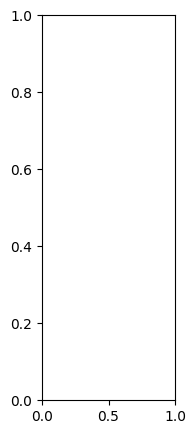

In [223]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_pred_test contains predicted classes for test data

# Display first few images and their predicted classes
num_images = 5
plt.figure(figsize=(10, 5))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(X_test_processed[i].reshape(28, 28), cmap='gray')
    plt.title(f"Predicted: {np.argmax(y_pred_test[i])}")
    plt.axis('off')

plt.tight_layout()
plt.show()
